## Imports

In [ ]:
import random
from dataclasses import dataclass

import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from copy import copy

from typing import Dict, Callable, Iterable, Union, Tuple, Sequence, Any, List, Optional

from matplotlib.ticker import MaxNLocator

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data loading

In [112]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5), (0.5))
     ])

mnist_train = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           download = True,
                                           transform = transform
                                           )



mnist_val = torchvision.datasets.MNIST(root = './data',
                                         train = False,
                                         download = True,
                                         transform = transform
                                         )


cifar_train = torchvision.datasets.CIFAR10(root = './data',
                                           train = True,
                                           download = True,
                                           transform = transform
                                           )

cifar_val = torchvision.datasets.CIFAR10(root = './data',
                                         train = False,
                                         download = True,
                                         transform = transform
                                         )


# limits dataset size for testing purposes
LIMIT = False
limit_cnt = 10000
if LIMIT:
    mnist_train = torch.utils.data.Subset(mnist_train, range(limit_cnt))
    mnist_val = torch.utils.data.Subset(mnist_val, range(limit_cnt))
    cifar_train = torch.utils.data.Subset(cifar_train, range(limit_cnt))
    cifar_val = torch.utils.data.Subset(cifar_val, range(limit_cnt))


Files already downloaded and verified
Files already downloaded and verified


In [57]:
# initial values and possible values for genetic algorithm
depths = [2, 3, 4, 5, 6]
activation_functions = [torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.Tanh(), torch.nn.LeakyReLU()]
neuron_per_layer = [16, 32, 64, 96, 128, 192, 256, 512]

In [58]:
@dataclass(eq = True, frozen = True)
class HiddenLayer:
    neurons: int
    activation_function: Callable

In [63]:
class NNmodel(torch.nn.Module):
    def __init__(self,
                    input_shape: int,
                    output_shape: int,
                    hidden_layers: Optional[List[HiddenLayer]] = None,
                    output_function: Callable = torch.nn.Softmax(dim = 1)
                 ):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hidden_layers = hidden_layers
        self.layers = None

        self.output_function = output_function
        self.fitness = 0

        if hidden_layers is not None:
            self.build_layers()

    def hash(self):
        return hash(tuple(self.hidden_layers))

    def build_layers(self):
        self.layers = nn.ModuleList()

        for i in range(len(self.hidden_layers)):
            if i == 0:
                self.layers.append(torch.nn.Linear(self.input_shape, self.hidden_layers[i].neurons))
            else:
                self.layers.append(torch.nn.Linear(self.hidden_layers[i-1].neurons, self.hidden_layers[i].neurons))
            if i == len(self.hidden_layers) - 1:
                self.layers.append(torch.nn.Linear(self.hidden_layers[i].neurons, self.output_shape))

    @staticmethod
    def create_random(input_shape: int, output_shape: int):
        depth = random.choice(depths)
        hidden_layers = [HiddenLayer(random.choice(neuron_per_layer), random.choice(activation_functions)) for _ in range(depth)]
        return NNmodel(input_shape, output_shape, hidden_layers)

    def forward(self, x):
        x = x.view(-1, self.input_shape)
        for i, layer in enumerate(self.layers[:-1]):
            x = self.hidden_layers[i].activation_function(layer(x))
        x = self.layers[-1](x)
        return x

    def predict(self, x):
        return self.output_function(self.forward(x))

    def set_fitness(self, fitness: float):
        self.fitness = fitness


def train(model: NNmodel,
          criterion,
          optimizer,
          train_loader):
    global device
    model.train()
    train_loss, train_correct = 0, 0

    model.zero_grad()
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = criterion(output, target)

        _, preds = torch.max(output.data, 1)

        train_loss += criterion(output, target).item()
        train_correct += torch.sum(preds == target).item()

        loss.backward()
        optimizer.step()
        model.zero_grad()

    train_loss /= len(train_loader)
    return train_loss, train_correct

def test(model: NNmodel,
            criterion,
            test_loader):
    global device
    model.eval()
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for data, target in test_loader:

            data = data.to(device)
            target = target.to(device)

            output = model(data)

            test_loss += criterion(output, target).item()

            _, preds = torch.max(output.data, 1)

            test_correct += torch.sum(preds == target).item()

    test_loss /= len(test_loader)
    return test_loss, test_correct

In [96]:
class Genetics:
    def __init__(self,
                 input_shape: int, # input shape of the model
                 output_shape: int, # output shape of the model
                 
                 train_loader,
                 val_loader, # data loaders for training and validation

                 generations: int = 50, # number of generations
                 population_size: int = 10, # number of individuals in population
                 mutation_rate: float = 0.05, # probability of mutation
                 crossover_rate: float = 0.5, # probability of crossover
                 crossover_function: Callable = None, # crossover function to use, if None, 1p crossover is used
                 epochs: int = 3,      # epochs for training each individual
                 epochs_final: int = 10,    # epochs for final training

                 criterion: Callable = torch.nn.CrossEntropyLoss, # loss function
                 optimizer: Callable = torch.optim.Adam, 
                 lr: float = 0.001):
        self.input_shape = input_shape
        self.output_shape = output_shape

        self.generations = generations
        self.population_size = population_size
        self.population = []
    
        if crossover_function is not None:
            self.crossover_function = crossover_function
        else:
            self.crossover_function = Genetics.crossover
            
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

        self.epochs = epochs
        self.epochs_final = epochs_final

        self.train_loader = train_loader
        self.val_loader = val_loader


        self.best_individual = None
        self.probabilities = None
        self.total_fitness = None
        self.test_acc = []
        self.train_acc = []

        self.criterion = criterion
        self.optimizer = optimizer
        self.lr = lr

        self.memory = {}
        self.fitted_results = None

    def initialize(self):
        self.population.clear()
        for _ in range(self.population_size):
            self.population.append(NNmodel.create_random(self.input_shape, self.output_shape))

    def fit_individual(self, indv: NNmodel, epochs: int):
        criterion = self.criterion()
        optimizer = self.optimizer(indv.parameters(), lr = 0.01)

        tr_loss, tr_acc = 0, 0
        ts_loss, ts_acc = 0, 0
        for i in range(epochs):
            # print(f'Epoch: {i+1}/{self.epochs}', end = '\r')
            tr_loss, tr_acc = train(indv, criterion, optimizer, self.train_loader)
            ts_loss, ts_acc = test(indv, criterion, self.val_loader)

        ts_acc = ts_acc / len(self.val_loader.dataset) * 100
        tr_acc = tr_acc / len(self.train_loader.dataset) * 100
        return tr_loss, tr_acc, ts_loss, ts_acc

    def evaluate_individual(self, indv: NNmodel):
        if indv.hash in self.memory:
            return self.memory[indv.hash]
        indv = indv.to(device)
        tr_loss, tr_acc, ts_loss, ts_acc = self.fit_individual(indv, self.epochs)

        indv.set_fitness(ts_acc)
        self.memory[indv.hash] = (tr_loss, tr_acc, ts_loss, ts_acc)
        return tr_loss, tr_acc, ts_loss, ts_acc

    def evaluate_population(self, population: List[NNmodel]):
        # evaluates the fitness of each individual in the population for current generation
        self.test_acc.append([])
        self.train_acc.append([])

        for i, indv in enumerate(population):
            print(f'Training individual {i+1}/{len(population)}', end= '\t')

            tr_loss, tr_acc, ts_loss, ts_acc = self.evaluate_individual(indv)

            self.test_acc[-1].append(ts_acc)
            self.train_acc[-1].append(tr_acc)
            print(f'Train loss: {tr_loss:.4f}, Train acc: {tr_acc:.2f} %, Test loss: {ts_loss:.4f}, Test acc: {ts_acc:.2f} %')

        for indv in population:
            if self.best_individual is None or indv.fitness > self.best_individual.fitness:
                self.best_individual = indv


    @staticmethod
    def select_roulete(population: List[NNmodel], probabilities) -> NNmodel:
        # selects an individual based on fitness
        return np.random.choice(population, p = probabilities)
    
    @staticmethod
    def select_turnament(population: List[NNmodel],
                         tournament_size: int = 3,
                         p: float = 0.9) -> NNmodel:
        # select individual with tournament selection
        tournament = random.sample(population, tournament_size)
        tournament.sort(key = lambda x: x.fitness, reverse = True)
        i = 0
        while True:
            if random.random() < p:
                return tournament[i]  
            i = (i + 1) % len(tournament)
        
    def prep_selection(self):
        # prepares the probabilities for roulete selection
        fitnesses = [indv.fitness for indv in self.population]
        self.total_fitness = sum(fitnesses)
        self.probabilities = [fitness/self.total_fitness for fitness in fitnesses]

    def generate_new_population(self):
        new_population = []
        self.prep_selection()

        for i in range(self.population_size):
            parent1 = Genetics.select_roulete(self.population, self.probabilities)
            parent2 = Genetics.select_roulete(self.population, self.probabilities)

            while parent1.hash == parent2.hash:
                parent2 = Genetics.select_roulete(self.population, self.probabilities)
            
            child = NNmodel(self.input_shape, self.output_shape, [])
            if random.random() < self.crossover_rate:
                child = self.crossover(parent1, parent2, child)
            else:
                child.hidden_layers = copy(parent1.hidden_layers)
                
            child = self.mutate(child)
            child.build_layers()
            new_population.append(child)

        self.population = new_population

    @staticmethod
    def crossover(parent1: NNmodel, parent2: NNmodel, child: NNmodel) -> NNmodel:
        # performs 1 point crossover
        # selects a random point and copies the layers before that point from parent1
        layer_cnt = min(len(parent1.hidden_layers), len(parent2.hidden_layers))
        point = random.randint(0, layer_cnt)
        p1_layers = parent1.hidden_layers[:point]
        p2_layers = parent2.hidden_layers[point:]

        child.hidden_layers = copy([*p1_layers, *p2_layers])

        return child

    @staticmethod
    def crossover2p(parent1: NNmodel, parent2: NNmodel, child: NNmodel) -> NNmodel:
        # performs 2 point crossover
        
        pl1, pl2 = len(parent1.hidden_layers), len(parent2.hidden_layers)
        layer_cnt = min(pl1, pl2)
        point1 = random.randint(0, layer_cnt)
        point2 = random.randint(point1, layer_cnt)

        p1, p2 = parent1 if pl1 > pl2 else parent2

        p1_layers = p1[:point1]
        p2_layers = p2[point1:point2]
        p1_layers2 = p1[point2:]

        child.hidden_layers = copy([*p1_layers, *p2_layers, *p1_layers2])

        return child

    @staticmethod
    def crossoverbitwise(parent1: NNmodel, parent2: NNmodel, child: NNmodel) -> NNmodel:
        # performs bitwise crossover
        # each layer is selected from a random parent
        pl1, pl2 = len(parent1.hidden_layers), len(parent2.hidden_layers)
        p1, p2 = parent1 if pl1 > pl2 else parent2
        layer_cnt = min(pl1, pl2)
        for i in range(layer_cnt):
            hlayer = p1[i] if random.random() < 0.5 else p2[i]
            child.hidden_layers.append(copy(hlayer))
        child.extend(*p1[layer_cnt:])

        return child

    def mutate(self, indv: NNmodel) -> NNmodel:
        # mutates the individual
        # performs mutation probability check for each layer
        # includes adding and removing layers
        
        for i in range(len(indv.hidden_layers)):
            layer = indv.hidden_layers[i]
            if random.random() < self.mutation_rate:
                indv.hidden_layers[i] = HiddenLayer(random.choice(neuron_per_layer), layer.activation_function)
            if random.random() < self.mutation_rate:
                indv.hidden_layers[i] = HiddenLayer(layer.neurons, random.choice(activation_functions))

        if random.random() < self.mutation_rate:
            indv.hidden_layers.append(HiddenLayer(random.choice(neuron_per_layer), random.choice(activation_functions)))
        if len(indv.hidden_layers) > 1 and random.random() < self.mutation_rate:
            indv.hidden_layers.remove(random.choice(indv.hidden_layers))
        return indv

    def run(self):
        # runs the genetic algorithm 
        # returns the best individual with extra training
        self.initialize()
        for i in range(self.generations):
            print(f'Generation: {i}')
            self.evaluate_population(self.population)
            self.generate_new_population()

        self.fitted_results = self.fit_individual(self.best_individual, self.epochs_final)
        return self.best_individual



## CIFAR10 dataset

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar_train,
                                           batch_size = 128,
                                           shuffle = True,
                                           drop_last = True
                                           )

val_loader = torch.utils.data.DataLoader(cifar_val,
                                         batch_size = 128,
                                         shuffle = False,
                                         drop_last = True
                                         )


In [106]:
genetics = Genetics(input_shape = 32*32*3,
                    output_shape = 10,

                    train_loader = train_loader,
                    val_loader = val_loader,

                    mutation_rate = 0.05,
                    generations = 15,
                    population_size = 20,
                    epochs = 5,
                    epochs_final = 10)
genetics.initialize()
genetics.run()

Generation: 0
Training individual 1/20	Train loss: 1.8386, Train acc: 32.60 %, Test loss: 1.9667, Test acc: 29.00 %
Training individual 2/20	Train loss: 2.2645, Train acc: 12.90 %, Test loss: 2.1889, Test acc: 14.45 %
Training individual 3/20	Train loss: 2.0346, Train acc: 19.50 %, Test loss: 2.1092, Test acc: 19.55 %
Training individual 4/20	Train loss: 1.9117, Train acc: 27.80 %, Test loss: 1.9306, Test acc: 28.60 %
Training individual 5/20	Train loss: 1.8457, Train acc: 30.25 %, Test loss: 1.9647, Test acc: 25.90 %
Training individual 6/20	Train loss: 1.3995, Train acc: 48.80 %, Test loss: 1.8344, Test acc: 34.15 %
Training individual 7/20	Train loss: 1.9097, Train acc: 23.85 %, Test loss: 2.0068, Test acc: 24.45 %
Training individual 8/20	Train loss: 1.8586, Train acc: 28.65 %, Test loss: 1.9734, Test acc: 27.00 %
Training individual 9/20	Train loss: 1.7392, Train acc: 34.05 %, Test loss: 1.9126, Test acc: 29.75 %
Training individual 10/20	Train loss: 1.7870, Train acc: 35.60 %, Te

NNmodel(
  (output_function): Softmax(dim=1)
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [107]:
min_series = [min(genetics.test_acc[i]) for i in range(len(genetics.test_acc))]
max_series = [max(genetics.test_acc[i]) for i in range(len(genetics.test_acc))]
mean_series = [np.mean(genetics.test_acc[i]) for i in range(len(genetics.test_acc))]

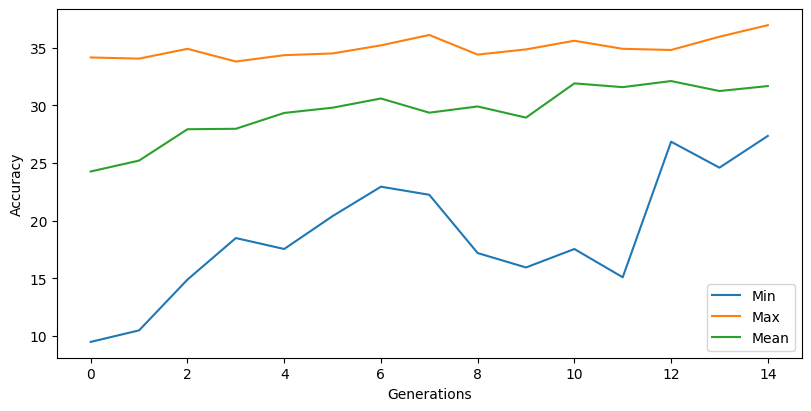

In [108]:
fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(min_series, label = 'Min')
plt.plot(max_series, label = 'Max')
plt.plot(mean_series, label = 'Mean')
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Accuracy")
plt.show()

In [109]:
genetics.fitted_results

(0.7346496899922689, 75.7, 4.433515898386637, 31.4)

## MNIST dataset

In [110]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size = 128,
                                           shuffle = True,
                                           drop_last = True
                                           )

val_loader = torch.utils.data.DataLoader(mnist_val,
                                         batch_size = 128,
                                         shuffle = False,
                                         drop_last = True
                                         )


In [113]:
genetics = Genetics(input_shape = 28*28,
                    output_shape = 10,

                    train_loader = train_loader,
                    val_loader = val_loader,

                    mutation_rate = 0.05,
                    generations = 15,
                    population_size = 30,
                    epochs = 5,
                    epochs_final = 10)
genetics.initialize()
genetics.run()

Generation: 0
Training individual 1/30	Train loss: 2.3019, Train acc: 10.96 %, Test loss: 2.3025, Test acc: 11.42 %
Training individual 2/30	Train loss: 2.2964, Train acc: 10.18 %, Test loss: 2.3020, Test acc: 11.42 %
Training individual 3/30	Train loss: 2.3016, Train acc: 11.18 %, Test loss: 2.3020, Test acc: 11.42 %
Training individual 4/30	Train loss: 1.5835, Train acc: 40.10 %, Test loss: 1.5264, Test acc: 38.82 %
Training individual 5/30	Train loss: 2.3029, Train acc: 10.20 %, Test loss: 2.3061, Test acc: 11.42 %
Training individual 6/30	Train loss: 2.3015, Train acc: 10.94 %, Test loss: 2.3017, Test acc: 11.42 %
Training individual 7/30	Train loss: 1.7424, Train acc: 31.78 %, Test loss: 1.7469, Test acc: 37.56 %
Training individual 8/30	Train loss: 1.8583, Train acc: 21.24 %, Test loss: 1.8839, Test acc: 23.36 %
Training individual 9/30	Train loss: 1.6345, Train acc: 33.40 %, Test loss: 1.7063, Test acc: 33.52 %
Training individual 10/30	Train loss: 1.3580, Train acc: 40.48 %, Te

NNmodel(
  (output_function): Softmax(dim=1)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=96, bias=True)
    (1): Linear(in_features=96, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [114]:
min_series = [min(genetics.test_acc[i]) for i in range(len(genetics.test_acc))]
max_series = [max(genetics.test_acc[i]) for i in range(len(genetics.test_acc))]
mean_series = [np.mean(genetics.test_acc[i]) for i in range(len(genetics.test_acc))]

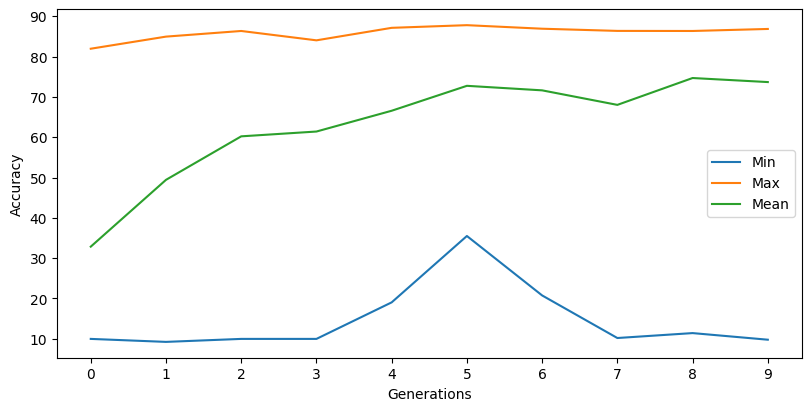

In [115]:
fig, ax = plt.subplots(figsize=(8, 4), layout='constrained')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(min_series, label = 'Min')
plt.plot(max_series, label = 'Max')
plt.plot(mean_series, label = 'Mean')
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Accuracy")
plt.show()